### Descripción del problema

Nota: Funcional. Descartamos las medidas de forest que solo tengan una direccion (up or down).  
Descartamos las medidas con errores de LAI alto.  
Descartamos las medidas con errores de clumping alto (up y down).  
Reservamos las medidas de 2023 para el test final.  
Eliminamos el outlier con id 20190918T154919_20190918T160136_T18SUJ.  
Seleccionamos las medidas insitu con una diferencia de dias menos de 5 dias con respecto a las adquisiciones del satelite.  
Implemento Feature Extraction.
Configurado para importar y procesar TOA reflectance

### Variables y librerías

Definimos variables importantes:

In [1243]:
#file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
file_name_sat = 'S2_TOArefl_USA_2017_2024.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

Importamos las librerías

In [1244]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import metrics

from variables import COORDS as coords

In [1245]:
# Montamos nuestro Google Drive si usamos entorno de Colab
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Datos de satelite

#### Cargamos el dataset de datos de satelite

Para entorno de **Google Colab**

In [1246]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path = drive_path + file_name_sat

Para entorno **local**

In [1247]:
# Definimos ruta de los archivos.
datadir_path = os.path.join('..','data')
dataset_path = os.path.join(datadir_path, file_name_sat)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [1248]:
df_sat = pd.read_csv(dataset_path, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_sat.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_sat.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,QA10,QA20,QA60,Site_sat
0,20170413T153911_20170413T154415_T18TYP,-71.287337,44.063892,1492098255730,3245.0,3065.0,2840.0,2890.0,3213.0,3911.0,4186.0,4149.0,4488.0,2129.0,3031.0,2832.0,0.0,0.0,1024,Bartlett Experimental Forest
1,20170413T153911_20170413T154415_T19TCJ,-71.287337,44.063892,1492098255730,3362.0,2910.0,2720.0,2790.0,3219.0,3917.0,4182.0,4047.0,4466.0,2200.0,3027.0,2813.0,0.0,0.0,1024,Bartlett Experimental Forest
2,20170503T153911_20170503T154436_T18TYP,-71.287337,44.063892,1493826276760,5621.0,5571.0,5323.0,5652.0,5839.0,6040.0,6220.0,6267.0,6383.0,4035.0,5224.0,4368.0,0.0,0.0,1024,Bartlett Experimental Forest
3,20170503T153911_20170503T154436_T19TCJ,-71.287337,44.063892,1493826276760,5626.0,5564.0,5306.0,5624.0,5833.0,6037.0,6220.0,6257.0,6388.0,4037.0,5222.0,4370.0,0.0,0.0,1024,Bartlett Experimental Forest
4,20170523T153911_20170523T154512_T18TYP,-71.287337,44.063892,1495554312840,1277.0,1039.0,1053.0,664.0,1246.0,2626.0,2954.0,2889.0,3203.0,1263.0,1370.0,695.0,0.0,0.0,2048,Bartlett Experimental Forest


In [1249]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27240 entries, 0 to 27239
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         27240 non-null  object 
 1   longitude  27240 non-null  float64
 2   latitude   27240 non-null  float64
 3   time       27240 non-null  int64  
 4   B1         27198 non-null  float64
 5   B2         27200 non-null  float64
 6   B3         27199 non-null  float64
 7   B4         27196 non-null  float64
 8   B5         27197 non-null  float64
 9   B6         27197 non-null  float64
 10  B7         27197 non-null  float64
 11  B8         27200 non-null  float64
 12  B8A        27194 non-null  float64
 13  B9         27198 non-null  float64
 14  B11        27197 non-null  float64
 15  B12        27194 non-null  float64
 16  QA10       23802 non-null  float64
 17  QA20       23802 non-null  float64
 18  QA60       27240 non-null  int64  
 19  Site_sat   27240 non-null  object 
dtypes: flo

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'time' que está en formato Unix epoch time.

In [1250]:
#df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))
df_sat['time'] = pd.to_datetime(df_sat['time'], unit='ms')
#df_sat['time'] = pd.to_datetime(df_sat['time'])

In [1251]:
df_sat['time']

0       2017-04-13 15:44:15.730
1       2017-04-13 15:44:15.730
2       2017-05-03 15:44:36.760
3       2017-05-03 15:44:36.760
4       2017-05-23 15:45:12.840
                  ...          
27235   2024-12-23 17:00:45.423
27236   2024-12-26 17:10:44.865
27237   2024-12-26 17:10:41.739
27238   2024-12-28 17:00:49.197
27239   2024-12-28 17:00:46.426
Name: time, Length: 27240, dtype: datetime64[ns]

**Ordenamos** el dataframe por Site y time, y **reseteamos** el indice.

In [1252]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

**Eliminamos columnas innecesarias.**  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [1253]:
df_sat.drop(columns=['B1', 'B9', 'QA10', 'QA20'], inplace=True)

**Eliminamos las filas** (espectros) correspondientes a **pixeles con nubes**  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [1254]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

27240

In [1255]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

QA60
0       18171
1024     6899
2048     2170
Name: count, dtype: int64

In [1256]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [1257]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

18171

**Elimino filas de no-vegetación**  
Me quedo con las filas (pixeles) de vegetación según la banda 'SCL' de Sentinel-2.  
Zonas de vegetación pueden estar cubiertas de nieve en alguna epoca del año.  
Por lo tanto, eliminamos esos pixeles.

In [1258]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

18171

In [1259]:
#df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

In [1260]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles

18171

**Escalamos las bandas** a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [1261]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'] # Definimos una lista con las columnas correspondientes a las bandas

In [1262]:
for banda in bandas: # Recorremos todas las bandas
    df_sat.loc[:,banda] = df_sat[banda].astype(float) # Forzamos el tipo de los datos para hacerlos float.
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001 # Escalamos

In [1263]:
# Vemos como queda nuestro dataset
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,QA60,Site_sat
6,20170612T153911_20170612T154905_T18TYP,-71.287337,44.063892,2017-06-12 15:49:05.350,0.1058,0.1028,0.0598,0.1183,0.3310,0.4187,0.3746,0.4532,0.1938,0.0781,0,Bartlett Experimental Forest
7,20170612T153911_20170612T154905_T19TCJ,-71.287337,44.063892,2017-06-12 15:49:05.350,0.1090,0.1076,0.0642,0.1178,0.3316,0.4207,0.3869,0.4546,0.1931,0.0777,0,Bartlett Experimental Forest
8,20170702T154421_20170702T154703_T18TYP,-71.287337,44.063892,2017-07-02 15:47:03.420,0.0826,0.0798,0.0421,0.0895,0.2805,0.3522,0.3282,0.3704,0.1565,0.0605,0,Bartlett Experimental Forest
9,20170702T154421_20170702T154703_T19TCJ,-71.287337,44.063892,2017-07-02 15:47:03.420,0.0822,0.0771,0.0402,0.0893,0.2810,0.3554,0.3148,0.3724,0.1560,0.0599,0,Bartlett Experimental Forest
10,20170717T153909_20170717T154916_T18TYP,-71.287337,44.063892,2017-07-17 15:49:16.170,0.1835,0.1789,0.1586,0.1915,0.3502,0.4261,0.4113,0.4560,0.2629,0.1682,0,Bartlett Experimental Forest


In [1264]:
# Función para eliminar outliers basado en el IQR
def eliminar_outliers_iqr(df, columnas):
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartílico
        limite_inferior = Q1 - 1.5 * IQR  # Límite inferior
        limite_superior = Q3 + 1.5 * IQR  # Límite superior

        # Filtrar los datos que están fuera de los límites
        df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    return df

# Eliminar outliers
df_sin_outliers = eliminar_outliers_iqr(df_sat, bandas)
df_sat = df_sin_outliers

#### Visualización y exploración

Visualizamos muestras de los espectros de vegetación en un gráfico

In [1265]:
# Definimos la longitud de onda central de las bandas
central_wl = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

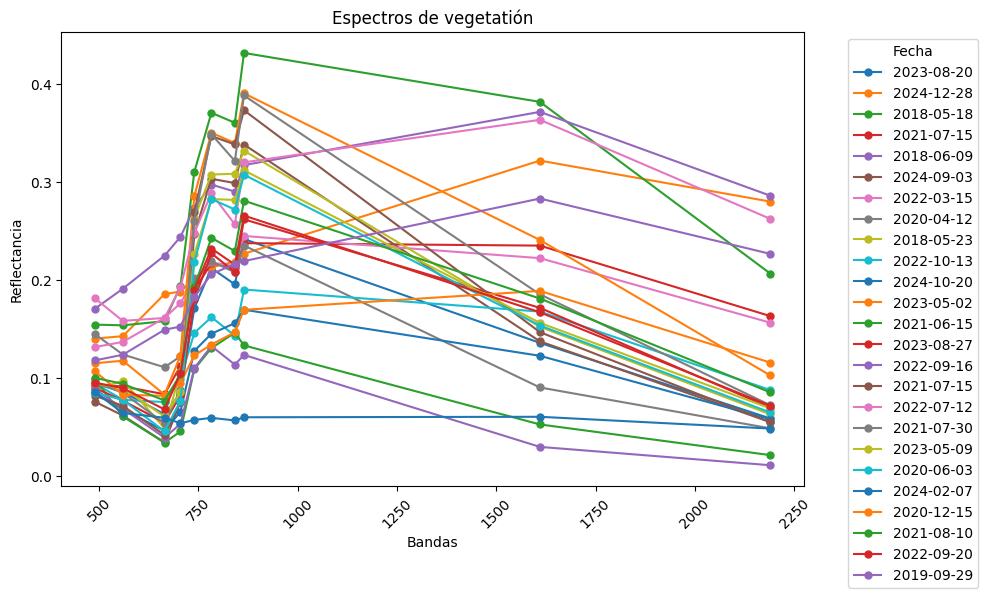

In [1266]:
# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

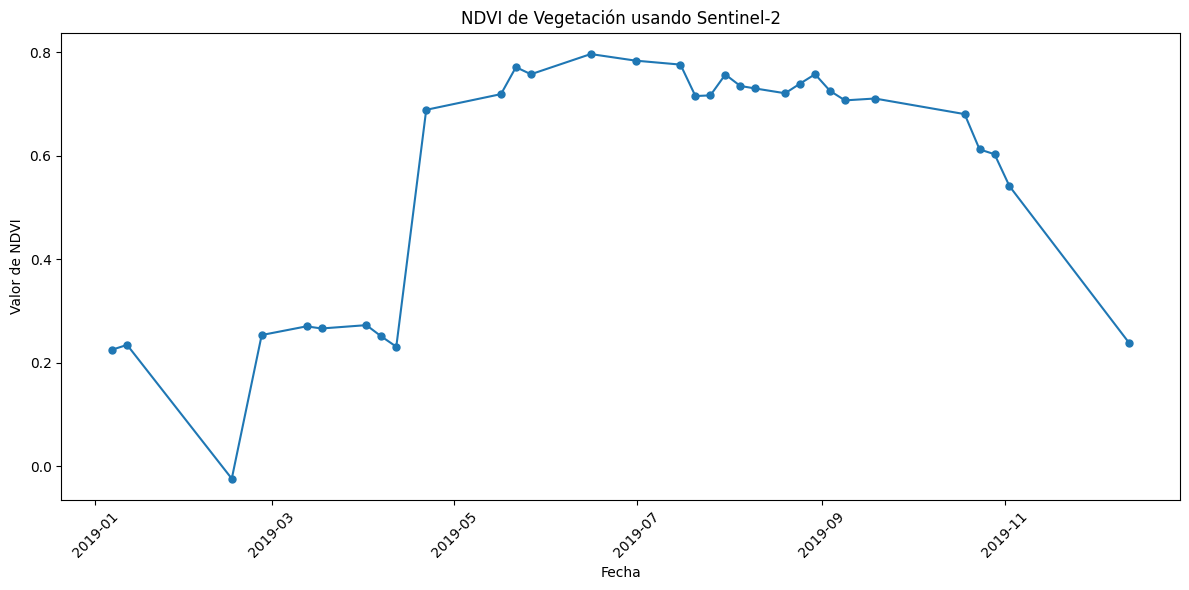

In [1267]:
# Calcular NDVI para cada espectro (fila) del DataFrame
df_VI = df_sat.copy()
df_VI['NDVI'] = (df_VI['B8'] - df_VI['B4']) / (df_VI['B8'] + df_VI['B4'])

# Graficar el NDVI para el site y el año seleccionado
plt.figure(figsize=(12, 6))
mask_Lajas_2019 = (df_VI['Site_sat'] == 'Smithsonian Environmental Research Center') & (df_VI['time'].dt.year == 2019)
plt.plot(df_VI.loc[mask_Lajas_2019,'time'], df_VI.loc[mask_Lajas_2019,'NDVI'], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### 2. Datos de campo

#### Cargamos el dataset de medidas insitu

Para entorno de **Google Colab**

In [1268]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path_insitu = drive_path + file_name_insitu

Para entorno **local**

In [1269]:
# Definimos ruta de los archivos.
#datadir_path = os.path.join('..','data')
dataset_path_insitu = os.path.join(datadir_path, file_name_insitu)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [1270]:
df_insitu = pd.read_csv(dataset_path_insitu, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_insitu.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_insitu.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,QA60,Site_sat
6,20170612T153911_20170612T154905_T18TYP,-71.287337,44.063892,2017-06-12 15:49:05.350,0.1058,0.1028,0.0598,0.1183,0.3310,0.4187,0.3746,0.4532,0.1938,0.0781,0,Bartlett Experimental Forest
7,20170612T153911_20170612T154905_T19TCJ,-71.287337,44.063892,2017-06-12 15:49:05.350,0.1090,0.1076,0.0642,0.1178,0.3316,0.4207,0.3869,0.4546,0.1931,0.0777,0,Bartlett Experimental Forest
8,20170702T154421_20170702T154703_T18TYP,-71.287337,44.063892,2017-07-02 15:47:03.420,0.0826,0.0798,0.0421,0.0895,0.2805,0.3522,0.3282,0.3704,0.1565,0.0605,0,Bartlett Experimental Forest
9,20170702T154421_20170702T154703_T19TCJ,-71.287337,44.063892,2017-07-02 15:47:03.420,0.0822,0.0771,0.0402,0.0893,0.2810,0.3554,0.3148,0.3724,0.1560,0.0599,0,Bartlett Experimental Forest
10,20170717T153909_20170717T154916_T18TYP,-71.287337,44.063892,2017-07-17 15:49:16.170,0.1835,0.1789,0.1586,0.1915,0.3502,0.4261,0.4113,0.4560,0.2629,0.1682,0,Bartlett Experimental Forest


In [1271]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   9406 non-null   object 
 1   Site                      9406 non-null   object 
 2   GROUND_DATA_PI            9176 non-null   object 
 3   GROUND_DATA_PIs_Email     9176 non-null   object 
 4   GBOV_Email                9406 non-null   object 
 5   Network                   9406 non-null   object 
 6   Elevation                 9406 non-null   int64  
 7   IGBP_class                9406 non-null   object 
 8   Lat_IS                    9406 non-null   float64
 9   Lon_IS                    9406 non-null   float64
 10  TIME_IS                   9406 non-null   object 
 11  Version                   9406 non-null   float64
 12  up_flag                   7713 non-null   float64
 13  down_flag                 7713 non-null   float64
 14  LAI_Mill

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'TIME_IS'

In [1272]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS'])

Pasamos todos los valores **nulos** a NaN

In [1273]:
valores_nulos = [-999.0, 999.0, -999, 999, '-999.0', '999.0', '-999', '999'] # Lista de valores a reemplazar por NaN
df_insitu.replace(valores_nulos, np.nan, inplace=True) # Reemplazar todos los valores por NaN
len(df_insitu)

9406

**Eliminamos filas** fijandonos en las columnas del **quality flag**

In [1274]:
# Nos quedamos con valores de up_flag = 0, que son los de mejor calidad, los demás los marcamos como nulos
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,'up_flag'] = np.nan

# Lo mismo para down_flag
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,'down_flag'] = np.nan

# Eliminamos filas donde ambas flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Definimos las **columnas numéricas**

In [1275]:
col_numericas = [
 'LAI_Miller_up',
 'LAI_Warren_up',
 'LAIe_Miller_up',
 'LAIe_Warren_up',
 'LAI_Miller_down',
 'LAI_Warren_down',
 'LAIe_Miller_down',
 'LAIe_Warren_down',
 'LAI_Miller_up_err',
 'LAI_Warren_up_err',
 'LAIe_Miller_up_err',
 'LAIe_Warren_up_err',
 'clumping_Miller_up',
 'clumping_Warren_up',
 'LAI_Miller_down_err',
 'LAI_Warren_down_err',
 'LAIe_Miller_down_err',
 'LAIe_Warren_down_err',
 'clumping_Miller_down',
 'clumping_Warren_down',
 'clumping_Miller_up_err',
 'clumping_Warren_up_err',
 'clumping_Miller_down_err',
 'clumping_Warren_down_err']

Miramos si existen **caracteres no numericos** en las columnas que impidan convertirlas a float.

In [1276]:
for col in col_numericas:
    # print('\n',col)
    for valor in df_insitu[col]:
        try:
            # Intentar convertir a float, si falla significa que el valor no es numérico
            valor = str(valor)
            float(valor)  # Intentar convertir a float
        except ValueError:
            # Si no se puede convertir, es un valor no numérico
            print(valor)


(7.2
(7.9
(8.0
(8.0
(8
(9
(7.2
(7.9
(8.0
(8.0
(8
(9
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05


Removemos caracteres no numericos y **forzamos el tipo de datos**

In [1277]:
for col in col_numericas:
    if df_insitu[col].dtypes != 'float':
        #print(col)
        # Limpiamos las columnas numericas de caracteres indeseados.
        df_insitu[col] = df_insitu[col].str.strip().str.replace('(', '').str.replace('(', '').str.replace(')', '')  # .str.replace("[^0-9.e]", '', regex=True)
        #df_insitu[col].astype(float, errors='ignore')
        df_insitu[col] =  pd.to_numeric(df_insitu[col],errors='coerce')


Visualizamos las diferentes clases de cubierta según 'IGBP_class'.  
Definimos las clases que forman parte de forest. 

In [1278]:
df_insitu['IGBP_class'].unique()

array(['Mixed Forest', 'Evergreen Needleleaf', 'Open Shrublands',
       'Croplands', 'Grasslands', 'Deciduous Broadleaf Forest',
       'Evergreen Broadleaf', 'Evergreen Needleleaf Forest',
       'Closed Shrublands', 'Deciduous Broadleaf'], dtype=object)

In [1279]:
class_forest = ['Mixed Forest', 'Evergreen Needleleaf', 'Deciduous Broadleaf Forest', 'Evergreen Broadleaf', 'Evergreen Needleleaf Forest','Deciduous Broadleaf']

Definimos las **quality flags** especificas para las medidas del método Warren ('Warren_up_flag','Warren_down_flag').  
Nos basamos en las quality flags generales ('up_flag' y 'down_flag').

In [1280]:
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), ['Warren_up_flag','Warren_down_flag']] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = 0


df_insitu.loc[(df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & (df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['up_flag'].isnull() & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_down'].notnull() & df_insitu['up_flag'].isnull() & df_insitu['down_flag'] == 0, 'Warren_down_flag'] = 0

**Calculamos el LAI y su error** en base a las quality flags.  
**Nota:** Nos quedamos con el LAI de las clases forest solo cuando tiene ambas medidas (LAI up y LAI down).

In [1281]:
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']


df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo downwards
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']


print(df_insitu['LAI_Warren'].isna().sum())

721


Eliminamos filas con **errores** más altos de LAI y de clumpling.

In [1282]:
# Descartamos medidas con errores mas altos
df_insitu = df_insitu[df_insitu['LAI_Warren_err'] <= 0.45]
df_insitu.loc[df_insitu['clumping_Warren_up_err'] >= 0.1,'LAI_Warren'] = np.nan
df_insitu.loc[df_insitu['clumping_Warren_down_err'] >= 0.35, 'LAI_Warren'] = np.nan

In [1283]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAI_Warren'], inplace=True)
len(df_insitu)

5850

Visualizamos la **información** del dataset para  ver como queda.

In [1284]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5850 entries, 0 to 9404
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   GBOV_ID                   5850 non-null   object             
 1   Site                      5850 non-null   object             
 2   GROUND_DATA_PI            5768 non-null   object             
 3   GROUND_DATA_PIs_Email     5768 non-null   object             
 4   GBOV_Email                5850 non-null   object             
 5   Network                   5850 non-null   object             
 6   Elevation                 5850 non-null   int64              
 7   IGBP_class                5850 non-null   object             
 8   Lat_IS                    5850 non-null   float64            
 9   Lon_IS                    5850 non-null   float64            
 10  TIME_IS                   5850 non-null   datetime64[ns, UTC]
 11  Version               

### 3. Combinación de los datasets

Quitamos el **dato UTC** a la columna fecha para estandarizarla con el dataset de satelite.

In [1285]:
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13 00:00:00+00:00
2,Harvard Forest,2018-08-13 00:00:00+00:00


In [1286]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13
2,Harvard Forest,2018-08-13


**Merge de data sets**. Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [1287]:
df_list = []
days_diff_max = 5 # Diferencia maxima (en días) entre la medida de satelite y la medida in situ

# Itera sobre cada coordenada
for site, lat, lon in coords:
    # Filtra el DataFrame de df_insitu y df_sat según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site]
    df_sat_site = df_sat[df_sat['Site_sat'] == site]

    rows = []

    # Itera sobre los datos de satélite y sobre los datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= days_diff_max: # Si la diferencia en dias es menor...
                # Crea una lista con la fila combinada de ambas fuentes de datos
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')


        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)


Vemos el resultado del dataset combinado (solo algunas columnas)

In [1288]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True) # Reordenamos por Site y time del satelite
df_cross[['Site','date_sat','date_insitu','delta']]

,Site,date_sat,date_insitu,delta
0,Harvard Forest,2017-05-03,2017-05-08,4 days 08:15:23.240000
1,Harvard Forest,2017-07-02,2017-07-05,2 days 08:12:56.580000
2,Harvard Forest,2017-07-17,2017-07-18,0 days 08:10:43.830000
3,Harvard Forest,2017-09-15,2017-09-12,3 days 15:48:14.670000
4,Harvard Forest,2017-10-10,2017-10-09,1 days 15:41:48.460000
...,...,...,...,...
1702,Disney Wilderness Preserve,2023-10-05,2023-10-03,2 days 00:55:30.152000
1703,Disney Wilderness Preserve,2023-10-15,2023-10-16,0 days 22:03:32.157000
1704,Disney Wilderness Preserve,2023-10-30,2023-10-30,0 days 02:05:31.280000
1705,Disney Wilderness Preserve,2023-11-09,2023-11-13,3 days 23:10:28.983000


In [1289]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        1707 non-null   object         
 1   longitude                 1707 non-null   float64        
 2   latitude                  1707 non-null   float64        
 3   time                      1707 non-null   datetime64[ns] 
 4   B2                        1707 non-null   float64        
 5   B3                        1707 non-null   float64        
 6   B4                        1707 non-null   float64        
 7   B5                        1707 non-null   float64        
 8   B6                        1707 non-null   float64        
 9   B7                        1707 non-null   float64        
 10  B8                        1707 non-null   float64        
 11  B8A                       1707 non-null   float64        
 12  B11   

Graficamos espectros de vegetación correspondientes a diferentes valores de LAI

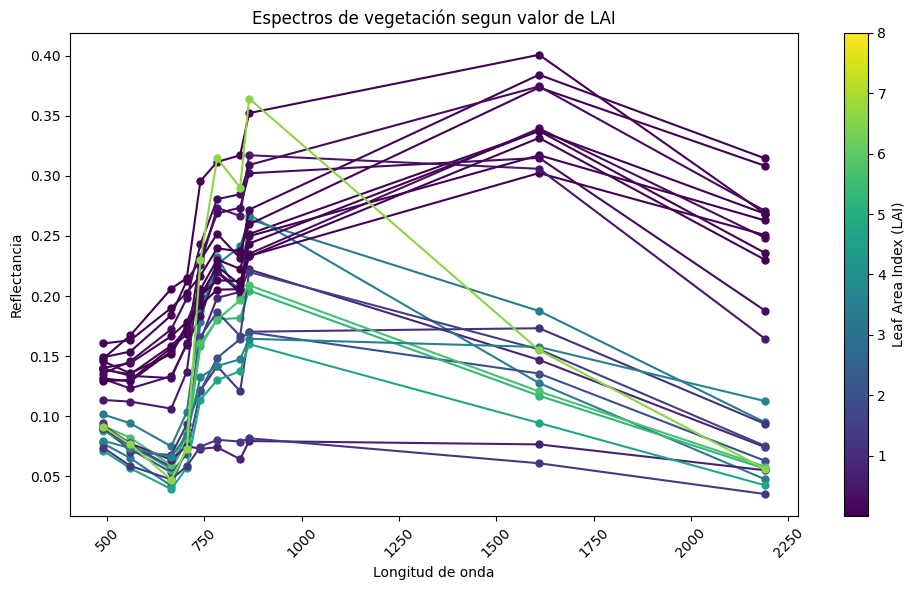

In [1290]:
# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una lista de colores basada en el valor de LAI
cmap = plt.get_cmap('viridis')  # Elegir un mapa de colores
norm = plt.Normalize(df_cross['LAI_Warren'].min(), df_cross['LAI_Warren'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAI_Warren']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación segun valor de LAI") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

Exportamos el dataframe a un archivo csv (opcional).

In [1291]:
#df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2023.csv')

### 4. Mini EDA

In [1292]:
#df_cross = df_cross[df_cross['LAI_Warren'] > 0.3] 

Verificamos si hay nulos en las bandas y en el target. Y los eliminamos.

In [1293]:
print(df_cross[bandas].isna().sum())
print('\nTarget:',df_cross['LAI_Warren'].isna().sum())
df_cross.dropna(subset=bandas, how='any', inplace=True)
df_cross.dropna(subset='LAI_Warren', inplace=True)

B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64

Target: 0


In [1294]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        1707 non-null   object         
 1   longitude                 1707 non-null   float64        
 2   latitude                  1707 non-null   float64        
 3   time                      1707 non-null   datetime64[ns] 
 4   B2                        1707 non-null   float64        
 5   B3                        1707 non-null   float64        
 6   B4                        1707 non-null   float64        
 7   B5                        1707 non-null   float64        
 8   B6                        1707 non-null   float64        
 9   B7                        1707 non-null   float64        
 10  B8                        1707 non-null   float64        
 11  B8A                       1707 non-null   float64        
 12  B11   

Verificamos si hay duplicados.

In [1295]:
df_cross.duplicated(subset=bandas, keep='first').sum()

0

Nos quedamos con los datos del 2017 al 2023. Reservamos los del 2024 para test final.

In [1296]:
df_cross = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')]

Eliminamos un outlier

In [1297]:
df_cross = df_cross[~(df_cross['id'] == '20190918T154919_20190918T160136_T18SUJ')]

Definimos variables a excluir

In [1298]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

Dividimos en train y test estratificando por la variable 'IGBP_class' que corresponde a los tipos de cubierta de vegetación.

In [1299]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_cross, test_size=0.2, stratify=df_cross['IGBP_class'] ,random_state=10)
print(len(train_set))
print(len(test_set))

1235
309


Definimos el target y las features

In [1300]:
target = 'LAI_Warren'

In [1301]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Definimos X_train, y_train

In [1302]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

Vemos la distribución de la variable objetivo.
Lamentablemente no tiene una distribución gausiana, lo que puede afectar ala algunos modelos como el de correlacion lineal.

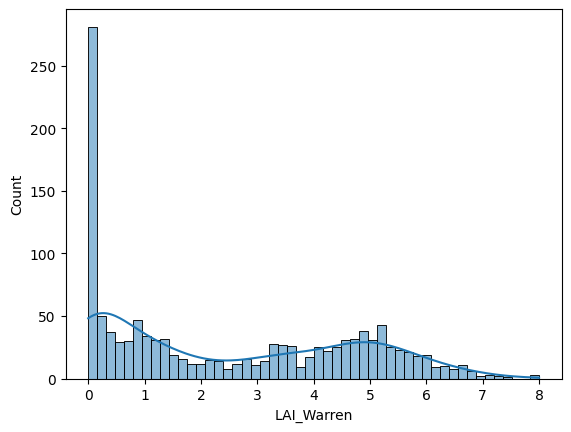

In [1303]:
sns.histplot(x= target, data = train_set, kde = True, bins=50);

Vemos los outliers

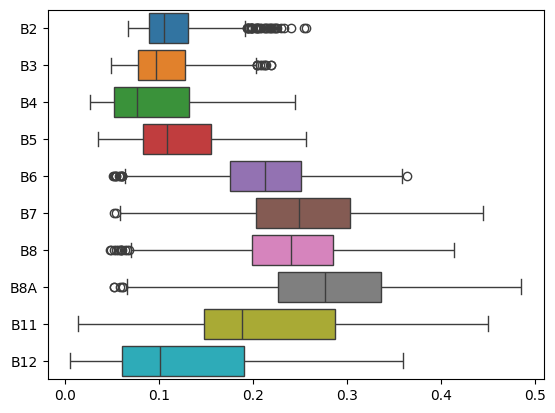

In [1304]:
sns.boxplot(data = train_set[bandas], orient = "h");

### Preparacion de features

Escalamos las features numericas (bandas) con un standar escalar. Necesario para modelos como la regresión lineal.

In [1305]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[bandas]), columns=bandas)

### Construccion de modelo base

#### Instanciamos y entrenamos una Linear regression

In [1306]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)


LinearRegression()

Resultados para **train**

In [1307]:
y_pred = lin_reg.predict(X_train_scaled)

In [1308]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train_scaled, y_train))

MSE: 1.2774852221959654
RMSE: 1.130258918211206
MAE: 0.8660566221348341
MAPE: 12.413346072963785
R2: 0.7381422609907236


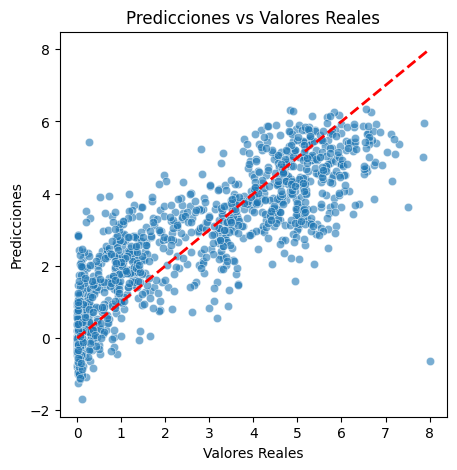

In [1309]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

Resultados para **test**

In [1310]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.1210513927827432
RMSE: 1.0587971443023179
MAE: 0.8502419103100621
MAPE: 12.652546411619225
R2: 0.7669589636219253


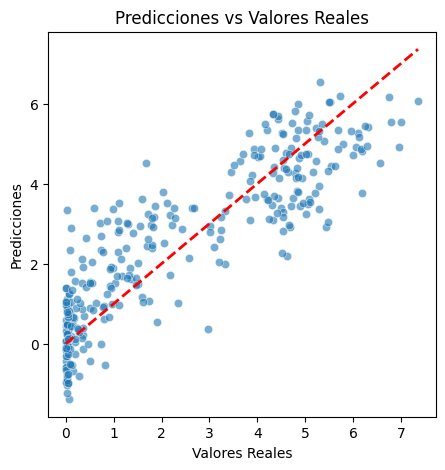

In [1311]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [1312]:
# Variable para contar cuántos valores de y_pred están dentro del 15% de y_test
count = 0

# Iterar a través de los elementos de y_test y y_pred
for y_t, y_p in zip(y_test, y_pred):
    if abs(y_p - y_t) <= 1:
        count += 1

print(f"Cantidad de valores de y_pred dentro de la unidad: {count}")

Cantidad de valores de y_pred dentro de la unidad: 197


In [1313]:
len(y_test)

309

In [1314]:
UAR = count/len(y_test)
UAR

0.6375404530744336

#### Elastic net

MSE: 1.3462323415701816
RMSE: 1.160272529007811
MAE: 0.93339507647926
MAPE: 10.849295689429292
R2: 0.720148976126381


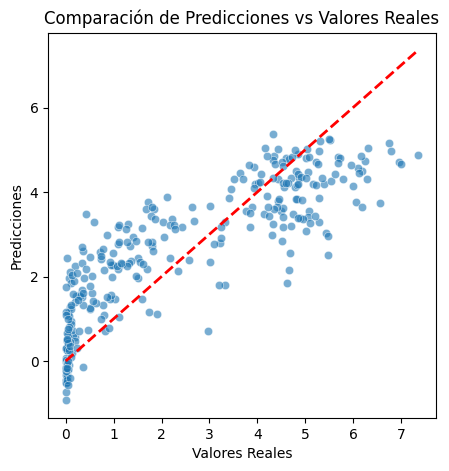

In [1315]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha= 0.2, l1_ratio= 0.1)
elastic_reg.fit(X_train_scaled,y_train)
y_pred = elastic_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', elastic_reg.score(X_test_scaled, y_test))

# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

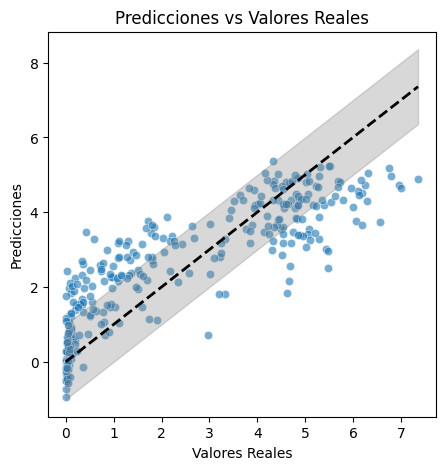

In [1316]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Sombrear el área entre las dos líneas paralelas (±1) en gris
plt.fill_between([y_test.min(), y_test.max()], 
                 [y_test.min() - 1, y_test.max() - 1], 
                 [y_test.min() + 1, y_test.max() + 1], 
                 color='gray', alpha=0.3)

# Línea diagonal que indica predicciones perfectas
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Mostrar el gráfico
plt.show()

### Feature selection

a) Selección de las mejores features con **análisis visual**

Aplicamos el test de significación de la correlación de Pearson, acudiendo a Scipy.  
Vemos que para todas las bandas pvalue  tien un  nivel de significacion deseado menor que 1. Lo que nos lleva a aceptar la hipotesis alternativa de que existe correlación significativa entre las features.

In [1317]:
from scipy.stats import  pearsonr

for col in bandas:
    print(col)
    print(pearsonr(train_set["LAI_Warren"], train_set[col]))

B2
PearsonRResult(statistic=-0.4342427101015509, pvalue=5.908739840712386e-58)
B3
PearsonRResult(statistic=-0.49626687507542366, pvalue=9.10514091579091e-78)
B4
PearsonRResult(statistic=-0.6398006939519343, pvalue=3.777394798633442e-143)
B5
PearsonRResult(statistic=-0.6015489065077086, pvalue=2.0263749634895829e-122)
B6
PearsonRResult(statistic=0.16693823007212158, pvalue=3.5877238526007267e-09)
B7
PearsonRResult(statistic=0.31182494607412237, pvalue=2.95886202239115e-29)
B8
PearsonRResult(statistic=0.28380456588768566, pvalue=2.6058920651686187e-24)
B8A
PearsonRResult(statistic=0.3062449328022734, pvalue=3.1604414021473403e-28)
B11
PearsonRResult(statistic=-0.6985459829893707, pvalue=1.9690691689057436e-181)
B12
PearsonRResult(statistic=-0.7130169497418521, pvalue=2.42868492505728e-192)


Vemos las features (bandas) mas correlacionadas con el target usando el metodo de Pandas corr que calcula el coeficiente de correlación de Pearson.  
Vemos que las bandas mas correlacionadas con el target son  las B12, B4, B11 y B5. Y las que menos la B6, B8A, B8 y B7.

In [1318]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

LAI_Warren    1.000000
B7            0.311825
B8A           0.306245
B8            0.283805
B6            0.166938
B2            0.434243
B3            0.496267
B5            0.601549
B4            0.639801
B11           0.698546
B12           0.713017
Name: LAI_Warren, dtype: float64

<Axes: >

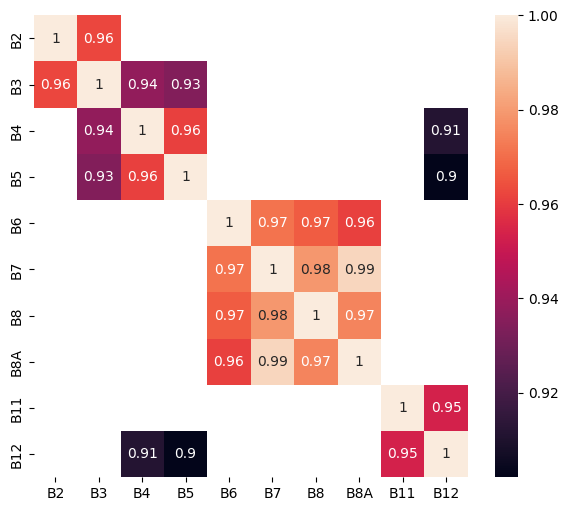

In [1319]:
corr = train_set[features].corr()
high_corr = corr[abs(corr) > 0.9]
plt.figure(figsize=(7,6))
sns.heatmap(abs(high_corr), annot=True)

La más alta correlación entre bandas es:  
B7-B8A del 100%.  
B6-B7 del 99%.  
B6-B8A del 99%.  
B7-B8 del 98%.  
B6-B8 del 97%.  
B8-B8A del 97%.


Descarto B8A, B6, B7 que tienen una alta correlacion y son las que menos correlación tienen con el target.  
También descarto B3 porque tiene alto correlación con B2 y B5.

In [1320]:
bandas_eliminar = ['B6','B8A', 'B7', 'B3']
bandas_sel = [banda for banda in bandas if banda not in bandas_eliminar]
bandas_sel

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [1321]:
X_train_visual = X_train[bandas_sel]
X_train_scaled_visual = X_train_scaled[bandas_sel]
X_train_scaled_visual.columns.to_list()

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [1322]:
from sklearn.ensemble import RandomForestRegressor

X = X_train[features]
Y = y_train

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
feat_score = pd.DataFrame(scores, columns=['Score', 'Feature'])
feat_score

,Score,Feature
0,0.4184,B11
1,0.2599,B12
2,0.0918,B8A
3,0.0487,B8
4,0.0406,B7
5,0.0391,B2
6,0.0292,B4
7,0.0272,B6
8,0.0231,B5
9,0.0219,B3


In [1323]:
X_train_selector = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector.columns.to_list()

['B2', 'B5', 'B7', 'B8A', 'B11', 'B12']

b) Selección de las mejores features usando un **modelo intermedio**

Selección de las mejores features a través de un modelo intermedio (usando **SelectFromModel**).  
Seleccionamos las bandas que queden con una importancia por encima de la mediana.

In [1324]:
'''from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

rf_selector = RandomForestRegressor(max_depth=5,random_state= 42)

selector_model = SelectFromModel(estimator = rf_selector, threshold= "median")
selector_model.fit(X_train,y_train) 
selector_model.get_feature_names_out()
X_train_selector = pd.DataFrame(selector_model.transform(X_train), columns = selector_model.get_feature_names_out())
X_train_scaled_selector = pd.DataFrame(selector_model.transform(X_train_scaled), columns = selector_model.get_feature_names_out())
X_train_scaled_selector'''

'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.feature_selection import SelectFromModel\n\nrf_selector = RandomForestRegressor(max_depth=5,random_state= 42)\n\nselector_model = SelectFromModel(estimator = rf_selector, threshold= "median")\nselector_model.fit(X_train,y_train) \nselector_model.get_feature_names_out()\nX_train_selector = pd.DataFrame(selector_model.transform(X_train), columns = selector_model.get_feature_names_out())\nX_train_scaled_selector = pd.DataFrame(selector_model.transform(X_train_scaled), columns = selector_model.get_feature_names_out())\nX_train_scaled_selector'

c) Selección de las mejores features empleando **RFE**

In [1325]:
from sklearn.feature_selection import RFE

rf_RFE = RandomForestRegressor(max_depth=5, random_state= 42)

rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 6, # Iterará hasta quedarse con 6
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = X_train.columns).sort_values("ranking")

[1 4 2 5 3 1 1 1 1 1]


,ranking
B2,1
B7,1
B8,1
B8A,1
B11,1
B12,1
B4,2
B6,3
B3,4
B5,5


In [1326]:
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
X_train_scaled_rfe = pd.DataFrame(rfe.transform(X_train_scaled), columns = rfe.get_feature_names_out())
X_train_rfe.columns.to_list()

['B2', 'B7', 'B8', 'B8A', 'B11', 'B12']

d) Selección de las mejores features empleando **SFS**

In [1327]:
from sklearn.feature_selection import SequentialFeatureSelector

rf_SFS = RandomForestRegressor(max_depth=5,random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "neg_mean_absolute_percentage_error")


sfs_forward.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
X_train_sfs = pd.DataFrame(sfs_forward.transform(X_train), columns = sfs_forward.get_feature_names_out())
X_train_scaled_sfs = pd.DataFrame(sfs_forward.transform(X_train_scaled), columns = sfs_forward.get_feature_names_out())
X_train_sfs.columns.to_list()

['B5', 'B6', 'B8', 'B8A', 'B11', 'B12']

Selección de las mejores features mediante un sistema de **hard-voting** aplicado a lo obtenido en los pasos 1 a 5 anteriores.

In [ ]:
from collections import Counter

# Unir todas las listas
all_features = X_train_selector.columns.to_list() + X_train_rfe.columns.to_list() + X_train_sfs.columns.to_list()

# Contar la frecuencia de cada feature
feature_counts = Counter(all_features)

# Ordenar las features por frecuencia
sorted_features = [feature for feature, count in feature_counts.most_common()]

# Mostrar la lista definitiva de features
print("Lista definitiva de features ordenadas por popularidad:")
sorted_features


Lista definitiva de features ordenadas por popularidad:


['B8A', 'B11', 'B12', 'B2', 'B5', 'B7', 'B8', 'B6']

In [ ]:
feature_counts

Counter({'B8A': 3,
         'B11': 3,
         'B12': 3,
         'B2': 2,
         'B5': 2,
         'B7': 2,
         'B8': 2,
         'B6': 1})

In [ ]:
X_train_hvote = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_hvote = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]

### Probar varios modelos. Comparación con Validación Cruzada (pre-optimización)

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","Random Forest","XGBoost","LightGBM","CatBoost"]

lr = LinearRegression()
rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state = 42)
lgb = LGBMRegressor(random_state= 42, verbose = -100)
cat  = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr, rf, xgb, lgb, cat]


metricas_cv = {}
valores = []
for nombre_modelo,modelo in zip(model_names, model_set):

    for nombre,set,set_scaled in zip(["Visual","SelectedFromModel", 'RFE', 'SFS','Hard voting',"Full_num_features"],[X_train_visual,  X_train_selector, X_train_rfe, X_train_sfs,X_train_hvote, X_train],[X_train_scaled_visual,  X_train_scaled_selector, X_train_scaled_rfe, X_train_scaled_sfs, X_train_scaled_hvote, X_train_scaled]):
        combinacion = nombre_modelo + "-" + nombre
        print(f"Para <{combinacion}> con <num_features: {len(set.columns.to_list())}>")
        print(modelo)
    
        if nombre_modelo != "Regresion Lineal":
            metricas_cv[combinacion] = cross_val_score(modelo, set, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
        else:
            metricas_cv[combinacion] = cross_val_score(modelo, set_scaled, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error") 
        print(-np.mean(metricas_cv[combinacion]), "\n")
        valores.append(-np.mean(metricas_cv[combinacion]))
ganador = list(metricas_cv.keys())[np.argmin(valores)]
best_score = np.min(valores)

Para <Regresion Lineal-Visual> con <num_features: 6>
LinearRegression()
0.572092743704043 

Para <Regresion Lineal-SelectedFromModel> con <num_features: 6>
LinearRegression()
0.5608281760761692 

Para <Regresion Lineal-RFE> con <num_features: 6>
LinearRegression()
0.5703268622513881 

Para <Regresion Lineal-SFS> con <num_features: 6>
LinearRegression()
0.5613590430934744 

Para <Regresion Lineal-Hard voting> con <num_features: 6>
LinearRegression()
0.5608281760761692 

Para <Regresion Lineal-Full_num_features> con <num_features: 10>
LinearRegression()
0.5478417390335414 

Para <Random Forest-Visual> con <num_features: 6>
RandomForestRegressor(random_state=42)
0.4721788034445667 

Para <Random Forest-SelectedFromModel> con <num_features: 6>
RandomForestRegressor(random_state=42)
0.4781254252116394 

Para <Random Forest-RFE> con <num_features: 6>
RandomForestRegressor(random_state=42)
0.47427859410336554 

Para <Random Forest-SFS> con <num_features: 6>
RandomForestRegressor(random_state=

In [ ]:
# Calcular la media de los valores
mean_values = {key: -np.mean(value) for key, value in metricas_cv.items()}

# Ordenar por media en orden descendente
sorted_mean_values = dict(sorted(mean_values.items(), key=lambda item: item[1]))

# Imprimir los resultados
for model, mean in sorted_mean_values.items():
    print(f"{model}: {mean:.4f}")

CatBoost-Full_num_features: 0.4587
Random Forest-SFS: 0.4609
CatBoost-Visual: 0.4658
Random Forest-Full_num_features: 0.4672
LightGBM-Full_num_features: 0.4703
Random Forest-Visual: 0.4722
CatBoost-SelectedFromModel: 0.4723
CatBoost-Hard voting: 0.4723
CatBoost-SFS: 0.4742
Random Forest-RFE: 0.4743
CatBoost-RFE: 0.4747
XGBoost-Full_num_features: 0.4751
XGBoost-Visual: 0.4760
LightGBM-Visual: 0.4778
Random Forest-SelectedFromModel: 0.4781
Random Forest-Hard voting: 0.4781
XGBoost-RFE: 0.4786
XGBoost-SFS: 0.4790
XGBoost-SelectedFromModel: 0.4818
XGBoost-Hard voting: 0.4818
LightGBM-RFE: 0.4909
LightGBM-SelectedFromModel: 0.4953
LightGBM-Hard voting: 0.4953
LightGBM-SFS: 0.4966
Regresion Lineal-Full_num_features: 0.5478
Regresion Lineal-SelectedFromModel: 0.5608
Regresion Lineal-Hard voting: 0.5608
Regresion Lineal-SFS: 0.5614
Regresion Lineal-RFE: 0.5703
Regresion Lineal-Visual: 0.5721


In [ ]:
print(f"El ganador es {ganador} con {best_score.round(4)}")

El ganador es CatBoost-Full_num_features con 0.4587


En  principio, viendo la validación cruzada (contra train) usando la feature selection tenemos mejores resultados. Y claramente la linear regresion tiene los perores resultados. 

El ganador es Catboost-SelectedFromModel. Sin embargo nos quedamos con el Random Forest-SFS ya que es un modelo mas simple y sencillo de explicar, además la diferencia en rendimiento no es muy significativa.  

Pero antes hay que probar contra test a ver si mejora con respecto al modelo base.

In [ ]:
rf_RFE_SFS = RandomForestRegressor(random_state= 42)
rf_RFE_SFS.fit(X_train_sfs,y_train)

y_pred = rf_RFE_SFS.predict(X_test[X_train_sfs.columns])
y_pred = pd.Series(y_pred, index=X_test.index, name='Predictions')

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', rf_RFE_SFS.score(X_test[X_train_sfs.columns], y_test))

MSE: 1.5017339991575362
RMSE: 1.2254525691178488
MAE: 0.8983370446800608
MAPE: 0.43536426222378277
R2: 0.6120973369991525


Contrario a lo que podríamos esperar, contra test el Random Forest-SFS (MAPE: 0.4670) practicamente no mejora con relacion al modelo LinearRegression-fullfeatures (MAPE: 0.4787).  

Esto nos lleva a quedarnos con el modelo más simple que es la regresion lineal, y usando todas las features.


In [ ]:
df_res = pd.DataFrame(y_test)

In [ ]:
df_res['pred'] = y_pred

In [ ]:
df_res['Class'] = test_set['IGBP_class']

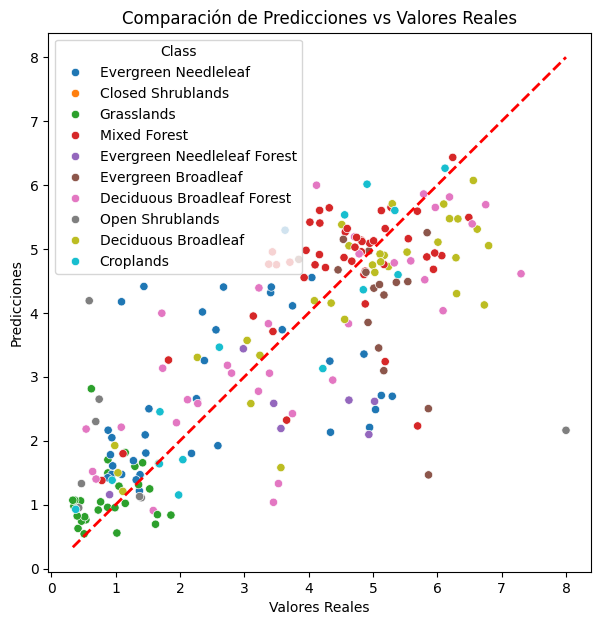

In [ ]:
plt.figure(figsize=(7, 7))

sns.scatterplot(data=df_res, x="LAI_Warren", y="pred", hue="Class")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()


### Analisis de errores

Calculamos los residuos y vemos la distribución de esos errores.

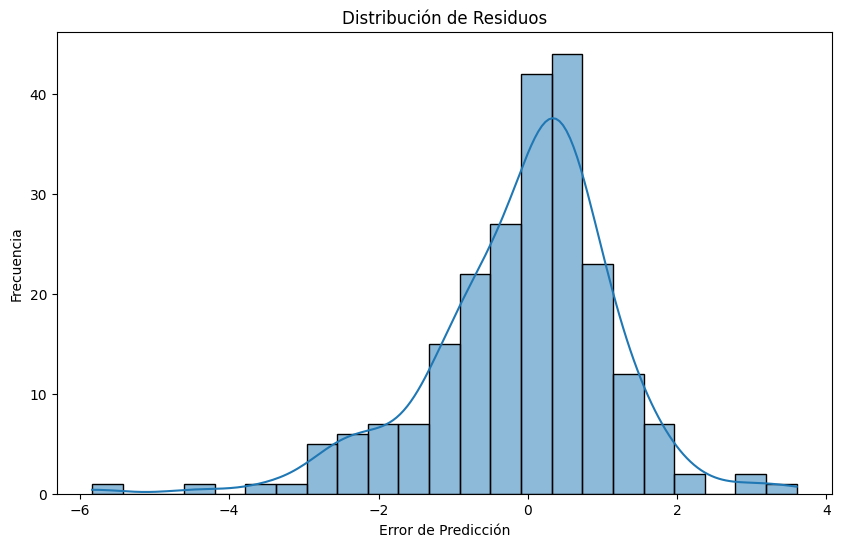

In [ ]:
# Calcular residuos
residuos = y_pred - y_test

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

Graficamos los residuos según el valor real para intentar ver patrones donde se concentran los errores.

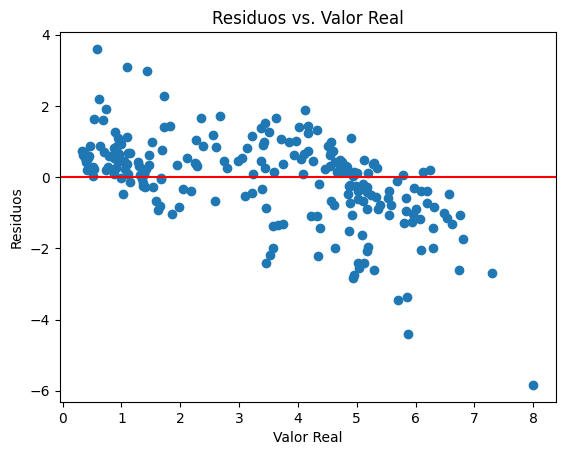

In [ ]:
# Gráfica de dispersión de residuos
plt.scatter(y_test, residuos)
plt.title('Residuos vs. Valor Real')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [ ]:
residuos

569     0.591985
610     0.632121
896     0.612036
1271    0.603988
1308    0.695573
          ...   
738     0.683212
87      0.411642
533    -3.461872
600     1.106185
383    -0.773313
Length: 226, dtype: float64

In [ ]:
test_set.columns

Index(['id', 'longitude', 'latitude', 'time', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B11', 'B12', 'QA60', 'Site_sat', 'GBOV_ID', 'Site',
       'GROUND_DATA_PI', 'GROUND_DATA_PIs_Email', 'GBOV_Email', 'Network',
       'Elevation', 'IGBP_class', 'Lat_IS', 'Lon_IS', 'TIME_IS', 'Version',
       'up_flag', 'down_flag', 'LAI_Miller_up', 'LAI_Warren_up',
       'LAIe_Miller_up', 'LAIe_Warren_up', 'LAI_Miller_down',
       'LAI_Warren_down', 'LAIe_Miller_down', 'LAIe_Warren_down',
       'LAI_Miller_up_err', 'LAI_Warren_up_err', 'LAIe_Miller_up_err',
       'LAIe_Warren_up_err', 'clumping_Miller_up', 'clumping_Warren_up',
       'LAI_Miller_down_err', 'LAI_Warren_down_err', 'LAIe_Miller_down_err',
       'LAIe_Warren_down_err', 'clumping_Miller_down', 'clumping_Warren_down',
       'clumping_Miller_up_err', 'clumping_Warren_up_err',
       'clumping_Miller_down_err', 'clumping_Warren_down_err',
       'Warren_up_flag', 'Warren_down_flag', 'LAI_Warren', 'LAI_Warren_err',
  

In [ ]:
test_set['LAIe_Warren'] = test_set['LAIe_Warren_up'].astype(float) + test_set['LAIe_Warren_down'].astype(float)

In [ ]:
test_set[abs(residuos) >= 2][['time','TIME_IS','delta','Site','IGBP_class','LAI_Warren','LAIe_Warren','LAI_Warren_down', 'LAI_Warren_err','LAIe_Warren_up','clumping_Warren_up','clumping_Warren_down','clumping_Warren_up_err','clumping_Warren_down_err']]

,time,TIME_IS,delta,Site,IGBP_class,LAI_Warren,LAIe_Warren,LAI_Warren_down,LAI_Warren_err,LAIe_Warren_up,clumping_Warren_up,clumping_Warren_down,clumping_Warren_up_err,clumping_Warren_down_err
1040,2019-08-06 16:44:28.334,2019-08-06 05:10:00,0 days 11:34:28.334000,Talladega National Forest,Evergreen Needleleaf,5.130000,3.530000,0.980000,0.260000,2.760000,0.670000,0.790000,0.040000,0.110000
1068,2019-07-16 18:54:20.813,2019-07-18 05:48:00,1 days 10:53:39.187000,Lower Teakettle,Evergreen Needleleaf Forest,5.025000,2.500969,0.219824,0.277125,2.329353,0.484759,0.780700,0.033941,0.330241
1434,2019-10-27 17:24:43.748,2019-10-29 07:54:00,1 days 14:29:16.252000,Lyndon B. Johnson National Grassland,Deciduous Broadleaf Forest,1.718380,0.972402,0.140928,0.208921,0.842682,0.534205,0.920470,0.081844,0.214661
1649,2019-08-27 16:15:30.427,2019-08-28 11:09:00,0 days 18:53:29.573000,Disney Wilderness Preserve,Open Shrublands,0.590000,NaN,0.590000,0.040000,NaN,NaN,0.930000,NaN,0.080000
1039,2019-07-22 16:44:32.718,2019-07-24 05:08:00,1 days 12:23:27.282000,Talladega National Forest,Evergreen Needleleaf,5.040000,3.340000,0.810000,0.270000,2.680000,0.630000,0.810000,0.040000,0.140000
618,2021-10-10 16:15:15.551,2021-10-06 08:05:00,4 days 08:10:15.551000,Ordway Swisher Biological Station,Evergreen Needleleaf,1.440000,1.025000,0.230000,0.114000,0.810000,0.660000,0.940000,0.060000,0.140000
612,2021-07-17 16:15:17.899,2021-07-13 07:03:00,4 days 09:12:17.899000,Ordway Swisher Biological Station,Evergreen Needleleaf,1.092000,0.803000,0.272000,0.100000,0.550000,0.680000,0.930000,0.080000,0.130000
1430,2019-08-28 17:24:41.640,2019-08-29 08:22:00,0 days 14:57:18.360000,Lyndon B. Johnson National Grassland,Deciduous Broadleaf Forest,3.531263,2.056956,0.363187,0.342697,1.751884,0.552981,0.839984,0.064696,0.192885
359,2018-08-26 16:43:04.750,2018-08-30 05:48:00,3 days 13:04:55.250000,Lenoir Landing,Deciduous Broadleaf Forest,6.089396,4.392902,0.269293,0.230754,4.154971,0.713900,0.883538,0.044688,0.151102
478,2021-07-19 18:33:10.386,2021-07-19 11:07:00,0 days 07:26:10.386000,Onaqui Ault,Open Shrublands,8.000000,NaN,8.000000,0.000019,NaN,NaN,1.000000,NaN,0.340000


<Axes: xlabel='LAI_Warren_err', ylabel='Count'>

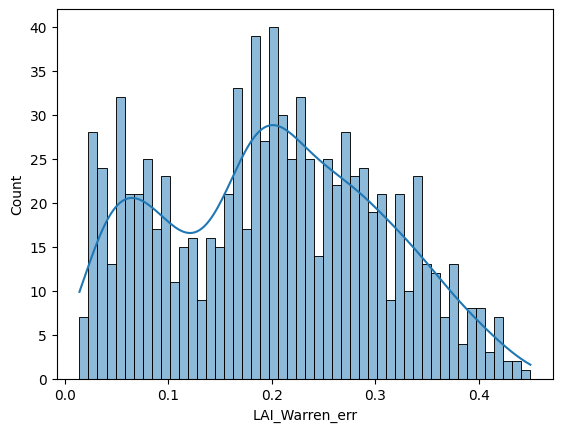

In [ ]:
sns.histplot(train_set['LAI_Warren_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_up_err', ylabel='Count'>

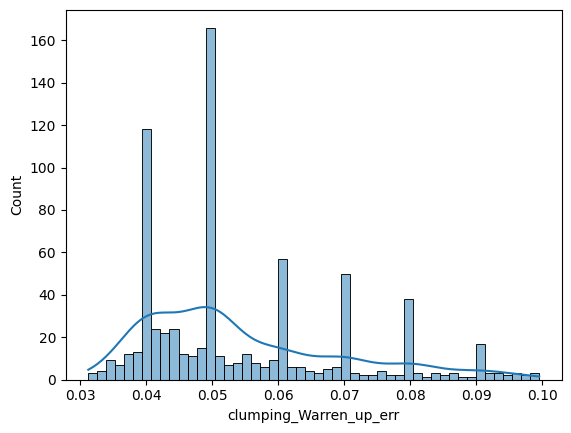

In [ ]:
sns.histplot(train_set['clumping_Warren_up_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_down_err', ylabel='Count'>

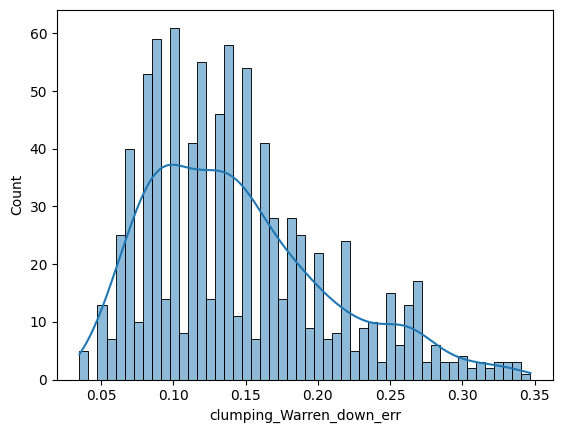

In [ ]:
sns.histplot(train_set['clumping_Warren_down_err'], kde=True, bins=50)

In [ ]:
test_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   47
Evergreen Needleleaf           38
Deciduous Broadleaf Forest     35
Deciduous Broadleaf            31
Grasslands                     29
Evergreen Broadleaf            16
Croplands                      14
Open Shrublands                 8
Evergreen Needleleaf Forest     7
Closed Shrublands               1
Name: count, dtype: int64

In [ ]:
train_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   187
Evergreen Needleleaf           152
Deciduous Broadleaf Forest     139
Deciduous Broadleaf            124
Grasslands                     114
Evergreen Broadleaf             62
Croplands                       55
Open Shrublands                 35
Evergreen Needleleaf Forest     30
Closed Shrublands                3
Name: count, dtype: int64

In [ ]:
df_cross['date_sat'] = pd.to_datetime(df_cross['date_sat'])

In [ ]:
test_set['IGBP_class'].value_counts()

IGBP_class
Mixed Forest                   47
Evergreen Needleleaf           38
Deciduous Broadleaf Forest     35
Deciduous Broadleaf            31
Grasslands                     29
Evergreen Broadleaf            16
Croplands                      14
Open Shrublands                 8
Evergreen Needleleaf Forest     7
Closed Shrublands               1
Name: count, dtype: int64

<Axes: xlabel='IGBP_class', ylabel='Count'>

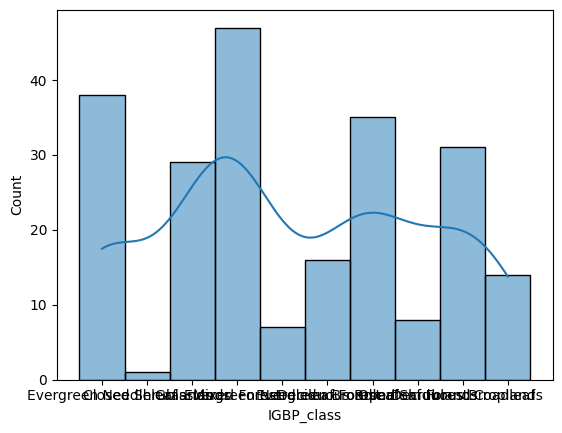

In [ ]:

sns.histplot(test_set['IGBP_class'], kde=True)

<Axes: xlabel='date_sat', ylabel='Count'>

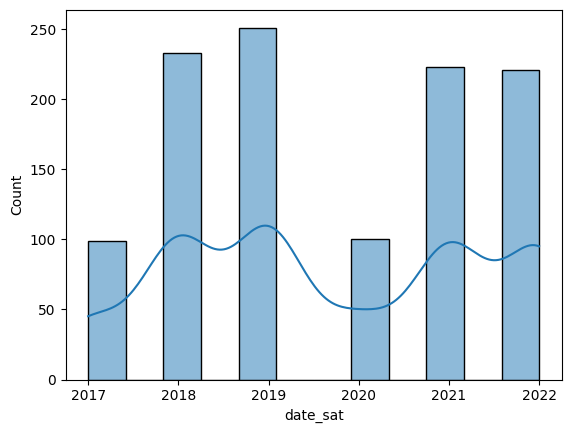

In [ ]:
sns.histplot(df_cross['date_sat'].dt.year, kde=True)